# Fashion Object Detection

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Import required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image
import io
import random

### Path to the training annotations JSON file

In [3]:
json_train_path = "annotations/instances_train2024.json"

### Load the training annotations JSON data

In [4]:
with open(json_train_path, "r") as f:
    data = json.load(f)

In [5]:
# Remove the "info" key
data.pop("info", None)

# Convert "categories" to a DataFrame
categories = pd.DataFrame(data["categories"])

# Convert "annotations" to a DataFrame
annotations = pd.DataFrame(data["annotations"])

In [6]:
categories 

,id,name,supercategory
0,8,trousers,deep fashion
1,1,short sleeve top,deep fashion
2,11,long sleeve dress,deep fashion
3,2,long sleeve top,deep fashion
4,9,skirt,deep fashion
5,7,shorts,deep fashion
6,4,long sleeve outwear,deep fashion
7,12,vest dress,deep fashion
8,10,short sleeve dress,deep fashion
9,5,vest,deep fashion


In [7]:
annotations

,segmentation,landmarks,category_id,is_crowd,bbox,id,image_id
0,"[[460, 438, 374, 484, 251, 520, 269, 586, 298,...","[251, 520, 1, 374, 484, 1, 460, 438, 1, 269, 5...",8,[0],"[249, 423, 217, 200]",1,000001
1,"[[257, 35, 261, 89, 228, 123, 137, 103, 45, 91...","[182, 54, 1, 45, 91, 1, 137, 103, 1, 228, 123,...",1,[0],"[0, 29, 466, 593]",2,000001
2,"[[220.25, 187.55, 259.6, 177.6, 296.6, 158.6, ...","[271, 172, 2, 313, 145, 2, 0, 0, 0, 0, 0, 0, 0...",1,[0],"[165, 133, 301, 439]",3,000002
3,"[[145.21, 314.0, 162.67, 312.8, 175.12, 313.05...","[127, 335, 1, 73, 340, 1, 107, 354, 1, 140, 35...",1,[0],"[1, 300, 366, 401]",4,000002
4,"[[338, 64, 299, 133, 228, 189, 183, 121, 160, ...","[240, 108, 2, 160, 63, 2, 183, 121, 2, 228, 18...",11,[0],"[1, 52, 466, 779]",5,000003
...,...,...,...,...,...,...,...
312181,"[[468, 173, 419, 169, 373, 171, 363, 263, 355,...","[373, 171, 1, 419, 169, 1, 468, 173, 1, 363, 2...",8,[0],"[347, 167, 127, 326]",312182,191959
312182,"[[125, 1, 161, 15, 165, 8, 171, 1, 175, 6, 174...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,[0],"[121, 0, 220, 102]",312183,191960
312183,"[[290, 77, 231, 73, 176, 73, 159, 188, 157, 31...","[176, 73, 1, 231, 73, 1, 290, 77, 1, 159, 188,...",8,[0],"[146, 69, 151, 409]",312184,191960
312184,"[[521, 6, 505, 20, 493, 32, 475, 77, 475, 107,...","[527, 7, 2, 0, 0, 0, 0, 0, 0, 493, 32, 2, 505,...",1,[0],"[469, 4, 84, 165]",312185,191961


### Sampling Images from dataset

In [8]:
# Assuming you have the data loaded into a DataFrame called 'annotations'
all_image_ids = annotations['image_id'].unique()  # Get a list of all unique image IDs

# Select a random sample of 1000 image IDs
sample_image_ids = random.sample(list(all_image_ids), 500)

# Create a new DataFrame with the sampled annotations
sampled_annotations = annotations[annotations['image_id'].isin(sample_image_ids)]

# Get all unique image IDs in the sampled dataset
sampled_image_ids = sampled_annotations['image_id'].unique()

# Create a new DataFrame with all annotations for the sampled image IDs
final_sampled_annotations = annotations[annotations['image_id'].isin(sampled_image_ids)]

print(f"Number of sampled annotations: {len(final_sampled_annotations)}")

Number of sampled annotations: 806


### Visualizing the category_id of the obtained dataset

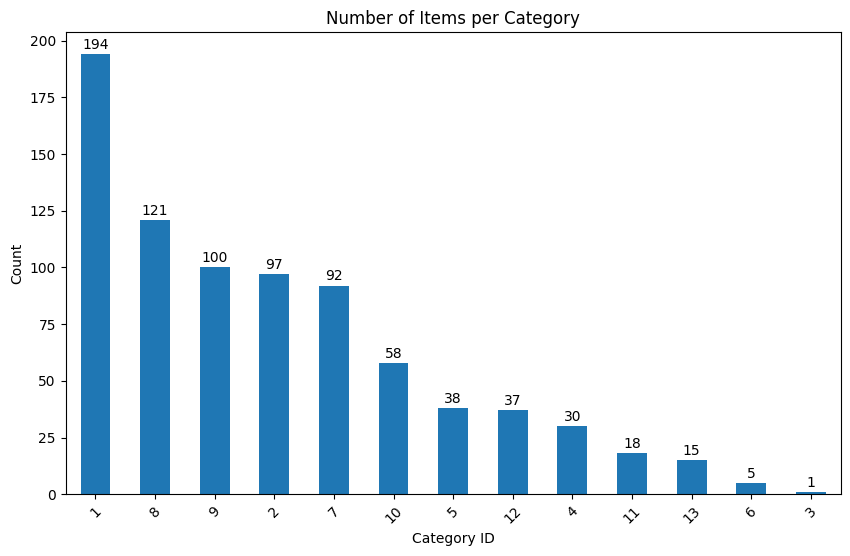

In [9]:
# Count the number of items in each category
category_counts = sampled_annotations['category_id'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')

# Add title and axis labels
plt.title('Number of Items per Category')
plt.xlabel('Category ID')
plt.ylabel('Count')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Annotate each bar with its count
for index, value in enumerate(category_counts):
    plt.text(index, value + 1, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

### Test Train Split

In [10]:
from sklearn.model_selection import train_test_split

# Convert category_id to categorical data type
final_sampled_annotations['category_id'] = final_sampled_annotations['category_id'].astype('category')
final_sampled_annotations

# Get the category counts across the entire dataset
category_counts = final_sampled_annotations['category_id'].value_counts()

# Filter out categories with fewer than 50 images
valid_categories = category_counts[category_counts >= 50].index

# Filter the dataset to include only valid categories
filtered_dataset = final_sampled_annotations[final_sampled_annotations['category_id'].isin(valid_categories)]

unique_categories = filtered_dataset['category_id'].unique()
category_mapping = {cat: idx for idx, cat in enumerate(unique_categories)}
filtered_dataset['remapped_category_id'] = filtered_dataset['category_id'].map(category_mapping)

unique_remapped_id = filtered_dataset['remapped_category_id'].unique()

json_data = filtered_dataset.to_json(orient='records')

# Write JSON data to a file
with open('json_annotations.json', 'w') as json_file:
    json_file.write(json_data)

# Display total number of unique categories
unique_categories_count = len(filtered_dataset['remapped_category_id'].unique())
print(f"Total number of unique categories with 50 or more images: {unique_categories_count}")

# Split the filtered dataset into train, val, and test sets
train_val_data, test_data = train_test_split(filtered_dataset, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Total number of unique categories with 50 or more images: 6
Train set size: 476
Validation set size: 119
Test set size: 67


In [11]:
sampled_annotations = pd.read_json('json_annotations.json')
sampled_annotations

,segmentation,landmarks,category_id,is_crowd,bbox,id,image_id,remapped_category_id
0,"[[401, 385, 343, 422, 266, 438, 278, 540, 296,...","[266, 438, 1, 343, 422, 2, 401, 385, 1, 278, 5...",7,[0],"[235, 372, 266, 272]",1006,617,0
1,"[[41, 100, 238, 102, 464, 133, 467, 376, 467, ...","[41, 100, 2, 238, 102, 2, 0, 0, 0, 0, 0, 0, 0,...",9,[0],"[0, 87, 467, 536]",1738,1083,1
2,"[[427, 622, 477, 606, 514, 592, 555, 677, 600,...","[514, 592, 1, 477, 606, 1, 427, 622, 1, 555, 6...",8,[0],"[416, 588, 265, 527]",2540,1549,2
3,"[[447, 410, 472, 410, 504, 475, 522, 532, 501,...","[462, 412, 2, 472, 410, 2, 0, 0, 0, 0, 0, 0, 0...",2,[0],"[374, 406, 154, 290]",2541,1549,3
4,"[[395.26, 360.18, 417.87, 361.74, 431.12, 369....","[395, 360, 2, 420, 366, 2, 448, 375, 2, 349, 3...",9,[0],"[186, 290, 345, 428]",3246,1973,1
...,...,...,...,...,...,...,...,...
657,"[[259, 63, 245, 94, 209, 119, 161, 95, 146, 62...","[214, 60, 1, 146, 62, 2, 161, 95, 2, 209, 119,...",1,[0],"[48, 60, 346, 343]",308137,189504,4
658,"[[463, 199, 457, 208, 443, 213, 428, 216, 413,...","[437, 203, 1, 413, 212, 2, 428, 216, 2, 443, 2...",10,[0],"[366, 193, 160, 214]",308251,189573,5
659,"[[175.0, 1.0, 294.0, 0.0, 361.0, 0.0, 419.0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 295, ...",8,[0],"[0, 1, 459, 531]",308700,189837,2
660,"[[422, 366, 402, 396, 374, 426, 350, 426, 343,...","[379, 380, 1, 343, 399, 2, 350, 426, 2, 374, 4...",10,[0],"[248, 360, 287, 473]",308715,189852,5


In [12]:
filtered_dataset

,segmentation,landmarks,category_id,is_crowd,bbox,id,image_id,remapped_category_id
1005,"[[401, 385, 343, 422, 266, 438, 278, 540, 296,...","[266, 438, 1, 343, 422, 2, 401, 385, 1, 278, 5...",7,[0],"[235, 372, 266, 272]",1006,000617,0.0
1737,"[[41, 100, 238, 102, 464, 133, 467, 376, 467, ...","[41, 100, 2, 238, 102, 2, 0, 0, 0, 0, 0, 0, 0,...",9,[0],"[0, 87, 467, 536]",1738,001083,1.0
2539,"[[427, 622, 477, 606, 514, 592, 555, 677, 600,...","[514, 592, 1, 477, 606, 1, 427, 622, 1, 555, 6...",8,[0],"[416, 588, 265, 527]",2540,001549,2.0
2540,"[[447, 410, 472, 410, 504, 475, 522, 532, 501,...","[462, 412, 2, 472, 410, 2, 0, 0, 0, 0, 0, 0, 0...",2,[0],"[374, 406, 154, 290]",2541,001549,3.0
3245,"[[395.26, 360.18, 417.87, 361.74, 431.12, 369....","[395, 360, 2, 420, 366, 2, 448, 375, 2, 349, 3...",9,[0],"[186, 290, 345, 428]",3246,001973,1.0
...,...,...,...,...,...,...,...,...
308136,"[[259, 63, 245, 94, 209, 119, 161, 95, 146, 62...","[214, 60, 1, 146, 62, 2, 161, 95, 2, 209, 119,...",1,[0],"[48, 60, 346, 343]",308137,189504,4.0
308250,"[[463, 199, 457, 208, 443, 213, 428, 216, 413,...","[437, 203, 1, 413, 212, 2, 428, 216, 2, 443, 2...",10,[0],"[366, 193, 160, 214]",308251,189573,5.0
308699,"[[175.0, 1.0, 294.0, 0.0, 361.0, 0.0, 419.0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 295, ...",8,[0],"[0, 1, 459, 531]",308700,189837,2.0
308714,"[[422, 366, 402, 396, 374, 426, 350, 426, 343,...","[379, 380, 1, 343, 399, 2, 350, 426, 2, 374, 4...",10,[0],"[248, 360, 287, 473]",308715,189852,5.0


In [13]:
# Determine the number of unique rows in each dataframe based on "image_id"
unique_rows_train = train_data['image_id'].nunique()
unique_rows_val = val_data['image_id'].nunique()
unique_rows_test = test_data['image_id'].nunique()

print(f"Unique rows in train set based on image_id: {unique_rows_train}")
print(f"Unique rows in validation set based on image_id: {unique_rows_val}")
print(f"Unique rows in test set based on image_id: {unique_rows_test}")

Unique rows in train set based on image_id: 353
Unique rows in validation set based on image_id: 115
Unique rows in test set based on image_id: 62


### Creating a sample Image folder

In [14]:
import os
import shutil

# Specify the original folder containing all images
original_folder = 'images/train/'

# Specify the new folder location for the main dataset
main_dataset_folder = 'main_dataset'

# Remove the main dataset folder if it exists to wipe out previous data
if os.path.exists(main_dataset_folder):
    shutil.rmtree(main_dataset_folder)

# Create the main dataset folder
os.makedirs(main_dataset_folder)

# Create the main dataset folder if it doesn't exist
os.makedirs(main_dataset_folder, exist_ok=True)

# Create subfolders for train, val, and test sets
train_folder = os.path.join(main_dataset_folder, 'train')
val_folder = os.path.join(main_dataset_folder, 'val')
test_folder = os.path.join(main_dataset_folder, 'test')

# Create subfolders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Copy images to the respective subfolders
for df, folder in zip([train_data, val_data, test_data], [train_folder, val_folder, test_folder]):
    for image_id in df['image_id'].unique():
        src_path = os.path.join(original_folder, f"{image_id}.jpg")  # Assuming images have .jpg extension
        if os.path.isfile(src_path):
            dst_path = os.path.join(folder, f"{image_id}.jpg")
            shutil.copy(src_path, dst_path)
        else:
            print(f"Image not found: {src_path}")

### Convert to YOLO Format

In [15]:
import os
import shutil
from tqdm import tqdm
import pandas as pd
from PIL import Image

# Load the sampled annotations
sampled_annotations = pd.read_json('json_annotations.json')

# Path to the split dataset folders
train_folder = 'main_dataset/train'
val_folder = 'main_dataset/val'
test_folder = 'main_dataset/test'

# Path to save the YOLO-formatted data
yolo_data_path = 'yolo_data'

# Remove the yolo_data folder if it exists
if os.path.exists(yolo_data_path):
    shutil.rmtree(yolo_data_path)

os.makedirs(yolo_data_path, exist_ok=True)

# Create separate folders for images and labels
for folder in ['train', 'val', 'test']:
    os.makedirs(os.path.join(yolo_data_path, folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(yolo_data_path, folder, 'labels'), exist_ok=True)

# Function to convert annotations to YOLO format
def convert_to_yolo_format(annotations, image_width, image_height):
    yolo_annotations = []
    for annotation in annotations:
        category_id = annotation['remapped_category_id']
        bbox = annotation['bbox']
        x_center = (bbox[0] + bbox[2] / 2) / image_width
        y_center = (bbox[1] + bbox[3] / 2) / image_height
        width = bbox[2] / image_width
        height = bbox[3] / image_height
        yolo_annotations.append(f"{category_id} {x_center} {y_center} {width} {height}")
    return yolo_annotations

# Function to process each dataset folder
def process_folder(folder_name, dataset_folder):
    for image_id in tqdm(os.listdir(dataset_folder), desc=f"Processing {folder_name}"):
        image_path = os.path.join(dataset_folder, image_id)
        if os.path.isfile(image_path):
            # Copy the image to the YOLO data folder
            shutil.copy(image_path, os.path.join(yolo_data_path, folder_name, 'images', image_id))

            # Get the image annotations from the sampled annotations
            image_annotations = sampled_annotations[sampled_annotations['image_id'] == int(image_id.split('.')[0])]

            if len(image_annotations) > 0:
                # Get the image dimensions
                image = Image.open(image_path)
                image_width, image_height = image.size

                # Convert annotations to YOLO format
                yolo_annotations = convert_to_yolo_format(image_annotations.to_dict('records'), image_width, image_height)

                # Save the YOLO annotations to a text file
                with open(os.path.join(yolo_data_path, folder_name, 'labels', image_id.split('.')[0] + '.txt'), 'w') as f:
                    f.write('\n'.join(yolo_annotations))

# Process each dataset folder
process_folder('train', train_folder)
process_folder('val', val_folder)
process_folder('test', test_folder)

Processing test: 100%|█████████████████████████| 62/62 [00:00<00:00, 434.29it/s]


### Find the No.of unique classes & names of classes

In [17]:
# Path to the dataset folder
dataset_path = f'/home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data'

# Get the number of classes from the annotations
num_classes = unique_categories_count

# Get the class names from the categories dataframe
class_names = filtered_dataset['remapped_category_id'].unique().tolist()

In [18]:
# Filter the DataFrame
filtered_df = categories[categories['id'].isin(class_names)]
filtered_df

# Create the dictionary
names = dict(zip(filtered_df['id'], filtered_df['name']))
print(names)

{1: 'short sleeve top', 2: 'long sleeve top', 4: 'long sleeve outwear', 5: 'vest', 3: 'short sleeve outwear'}


### Create a data.yaml file

In [19]:
import os
home = os.getcwd()

# Create the data.yml content
data_yml_content = f"""\
# Data path
path: {dataset_path}

# Train and validation data as 1) dict or 2) list of dict
train: {dataset_path}/train/images
val: {dataset_path}/val/images
test: {dataset_path}/test/images


# Classes
nc: {num_classes}
names: {class_names}
"""

# Save the data.yml file
with open('data.yaml', 'w', encoding='utf-8') as f:
    f.write(data_yml_content)

### Train your model

In [28]:
# train yolov9 models
!python yolov9/train_dual.py \
--workers 8 \
--device 0 \
--batch 4 \
--data data.yaml \
--img 640 \
--cfg /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolov9/models/detect/yolov9-c.yaml \
--weights /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/weights/gelan-c.pt \
--name yolov9-c \
--hyp hyp.scratch-high.yaml \
--min-items 0 \
--epochs 10 

train_dual: weights=/home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/weights/gelan-c.pt, cfg=/home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolov9/models/detect/yolov9-c.yaml, data=data.yaml, hyp=hyp.scratch-high.yaml, epochs=10, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov9/runs/train, name=yolov9-c, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=0, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 1e33dbb Python-3.12.3 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, wa

        3/9      5.66G      4.018       5.67      5.323          4        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        115        185    0.00262      0.119     0.0074    0.00271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        4/9      5.66G      4.027      5.657      5.283          1        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        115        185    0.00792     0.0407    0.00415    0.00147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        5/9      5.66G      4.094      5.645      5.254          1        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all        115        185    0.00326     0.0389    0.00305    0.00113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        6/

In [29]:
!ls /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolov9/runs/train/exp/

events.out.tfevents.1714849057.akshay.104951.0	hyp.yaml  opt.yaml  weights


In [30]:
HOME = "/home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion"

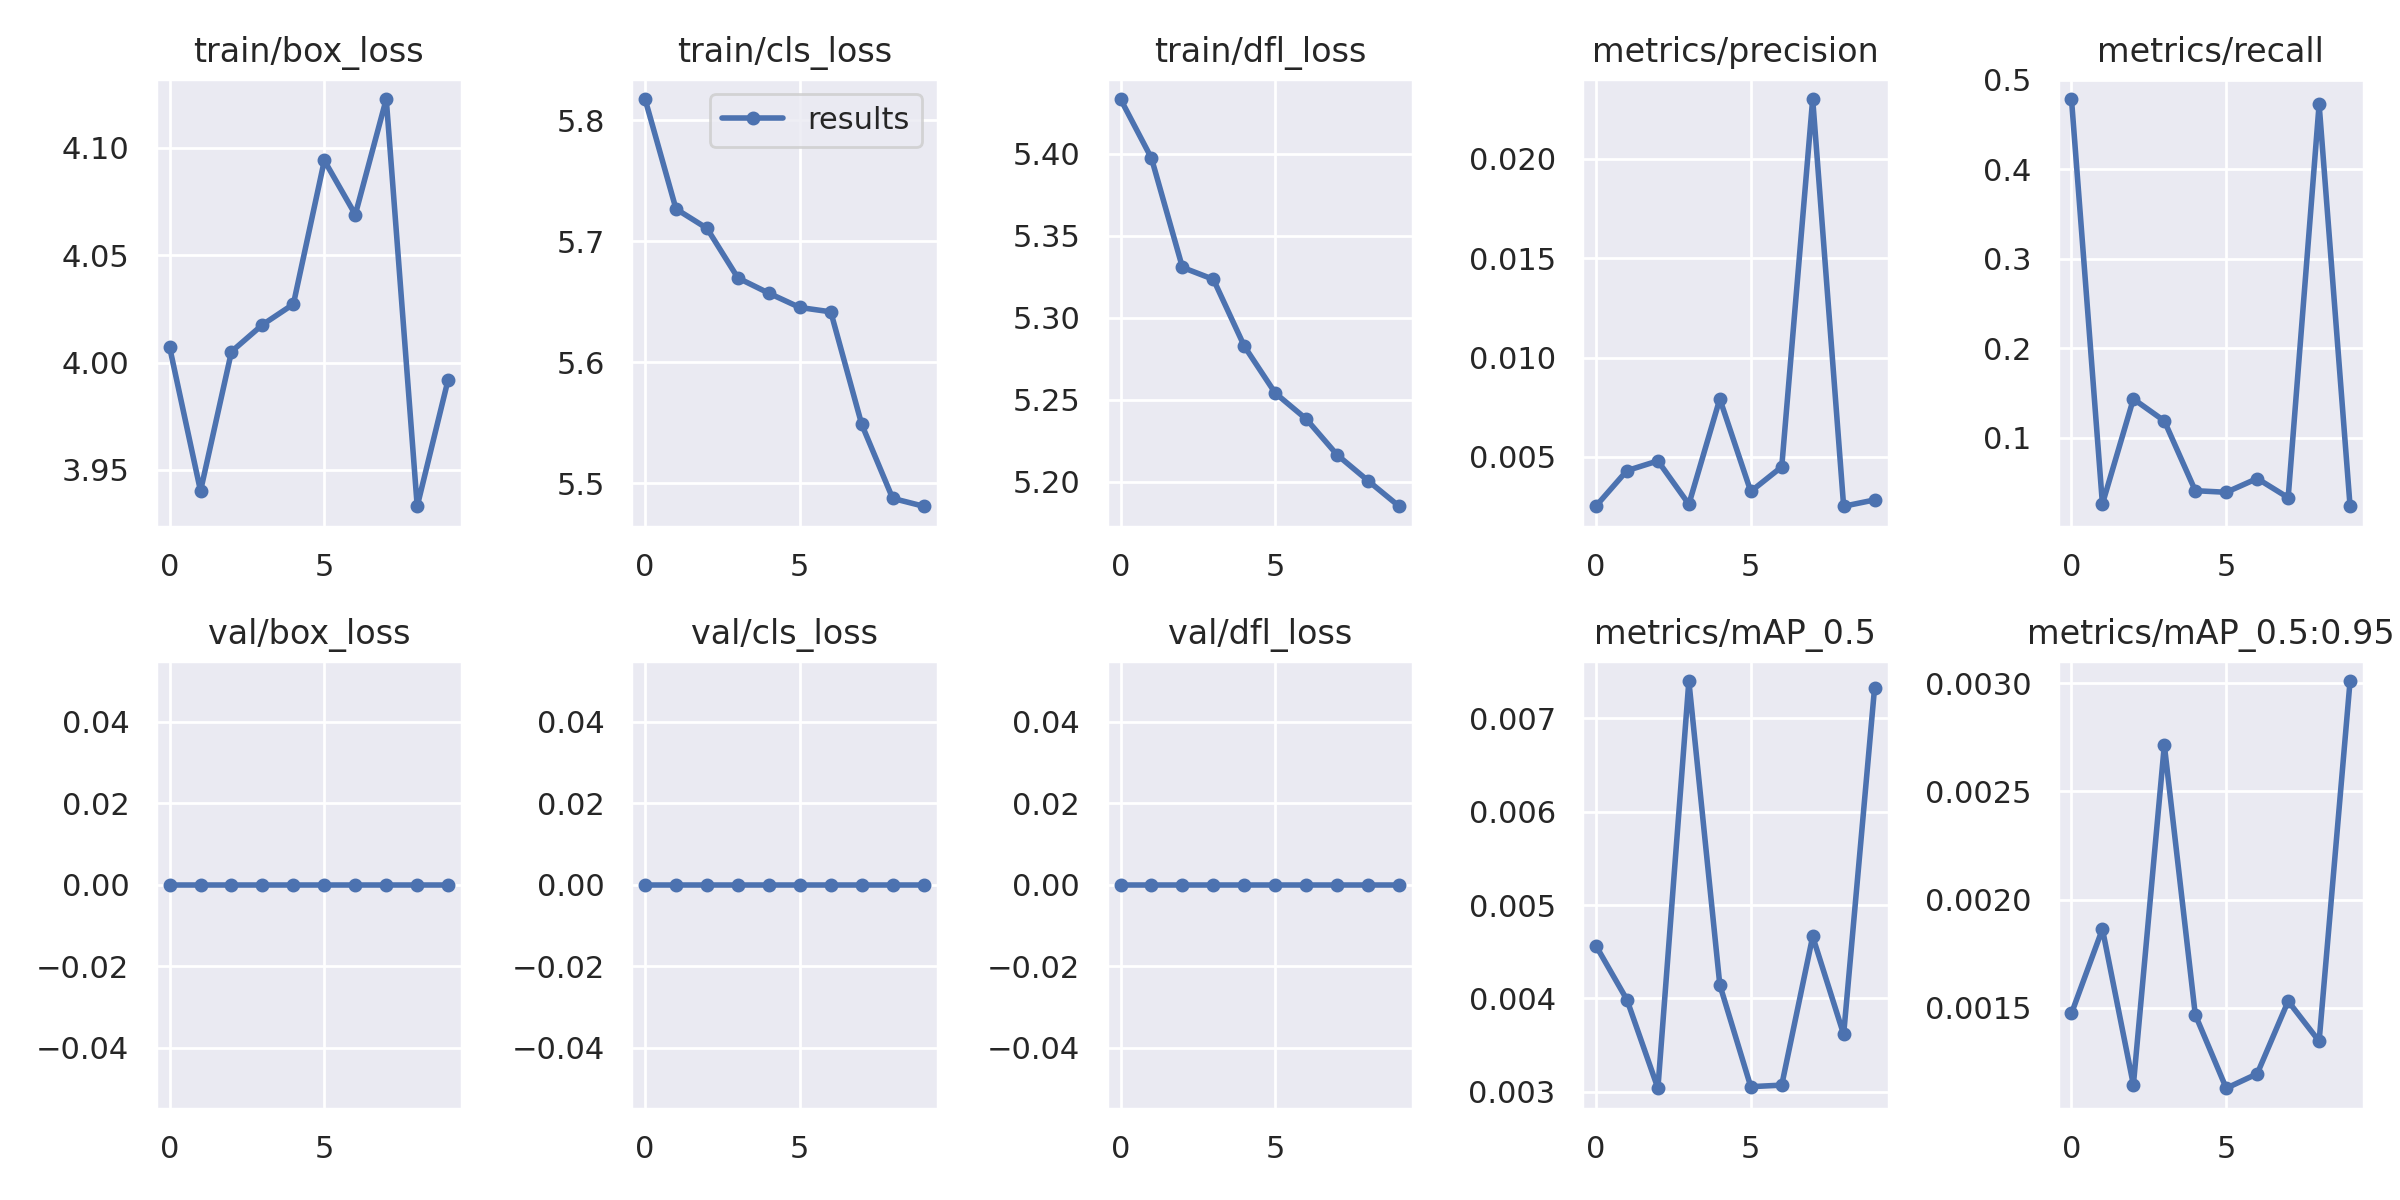

In [32]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/yolov9-c10/results.png", width=1000)

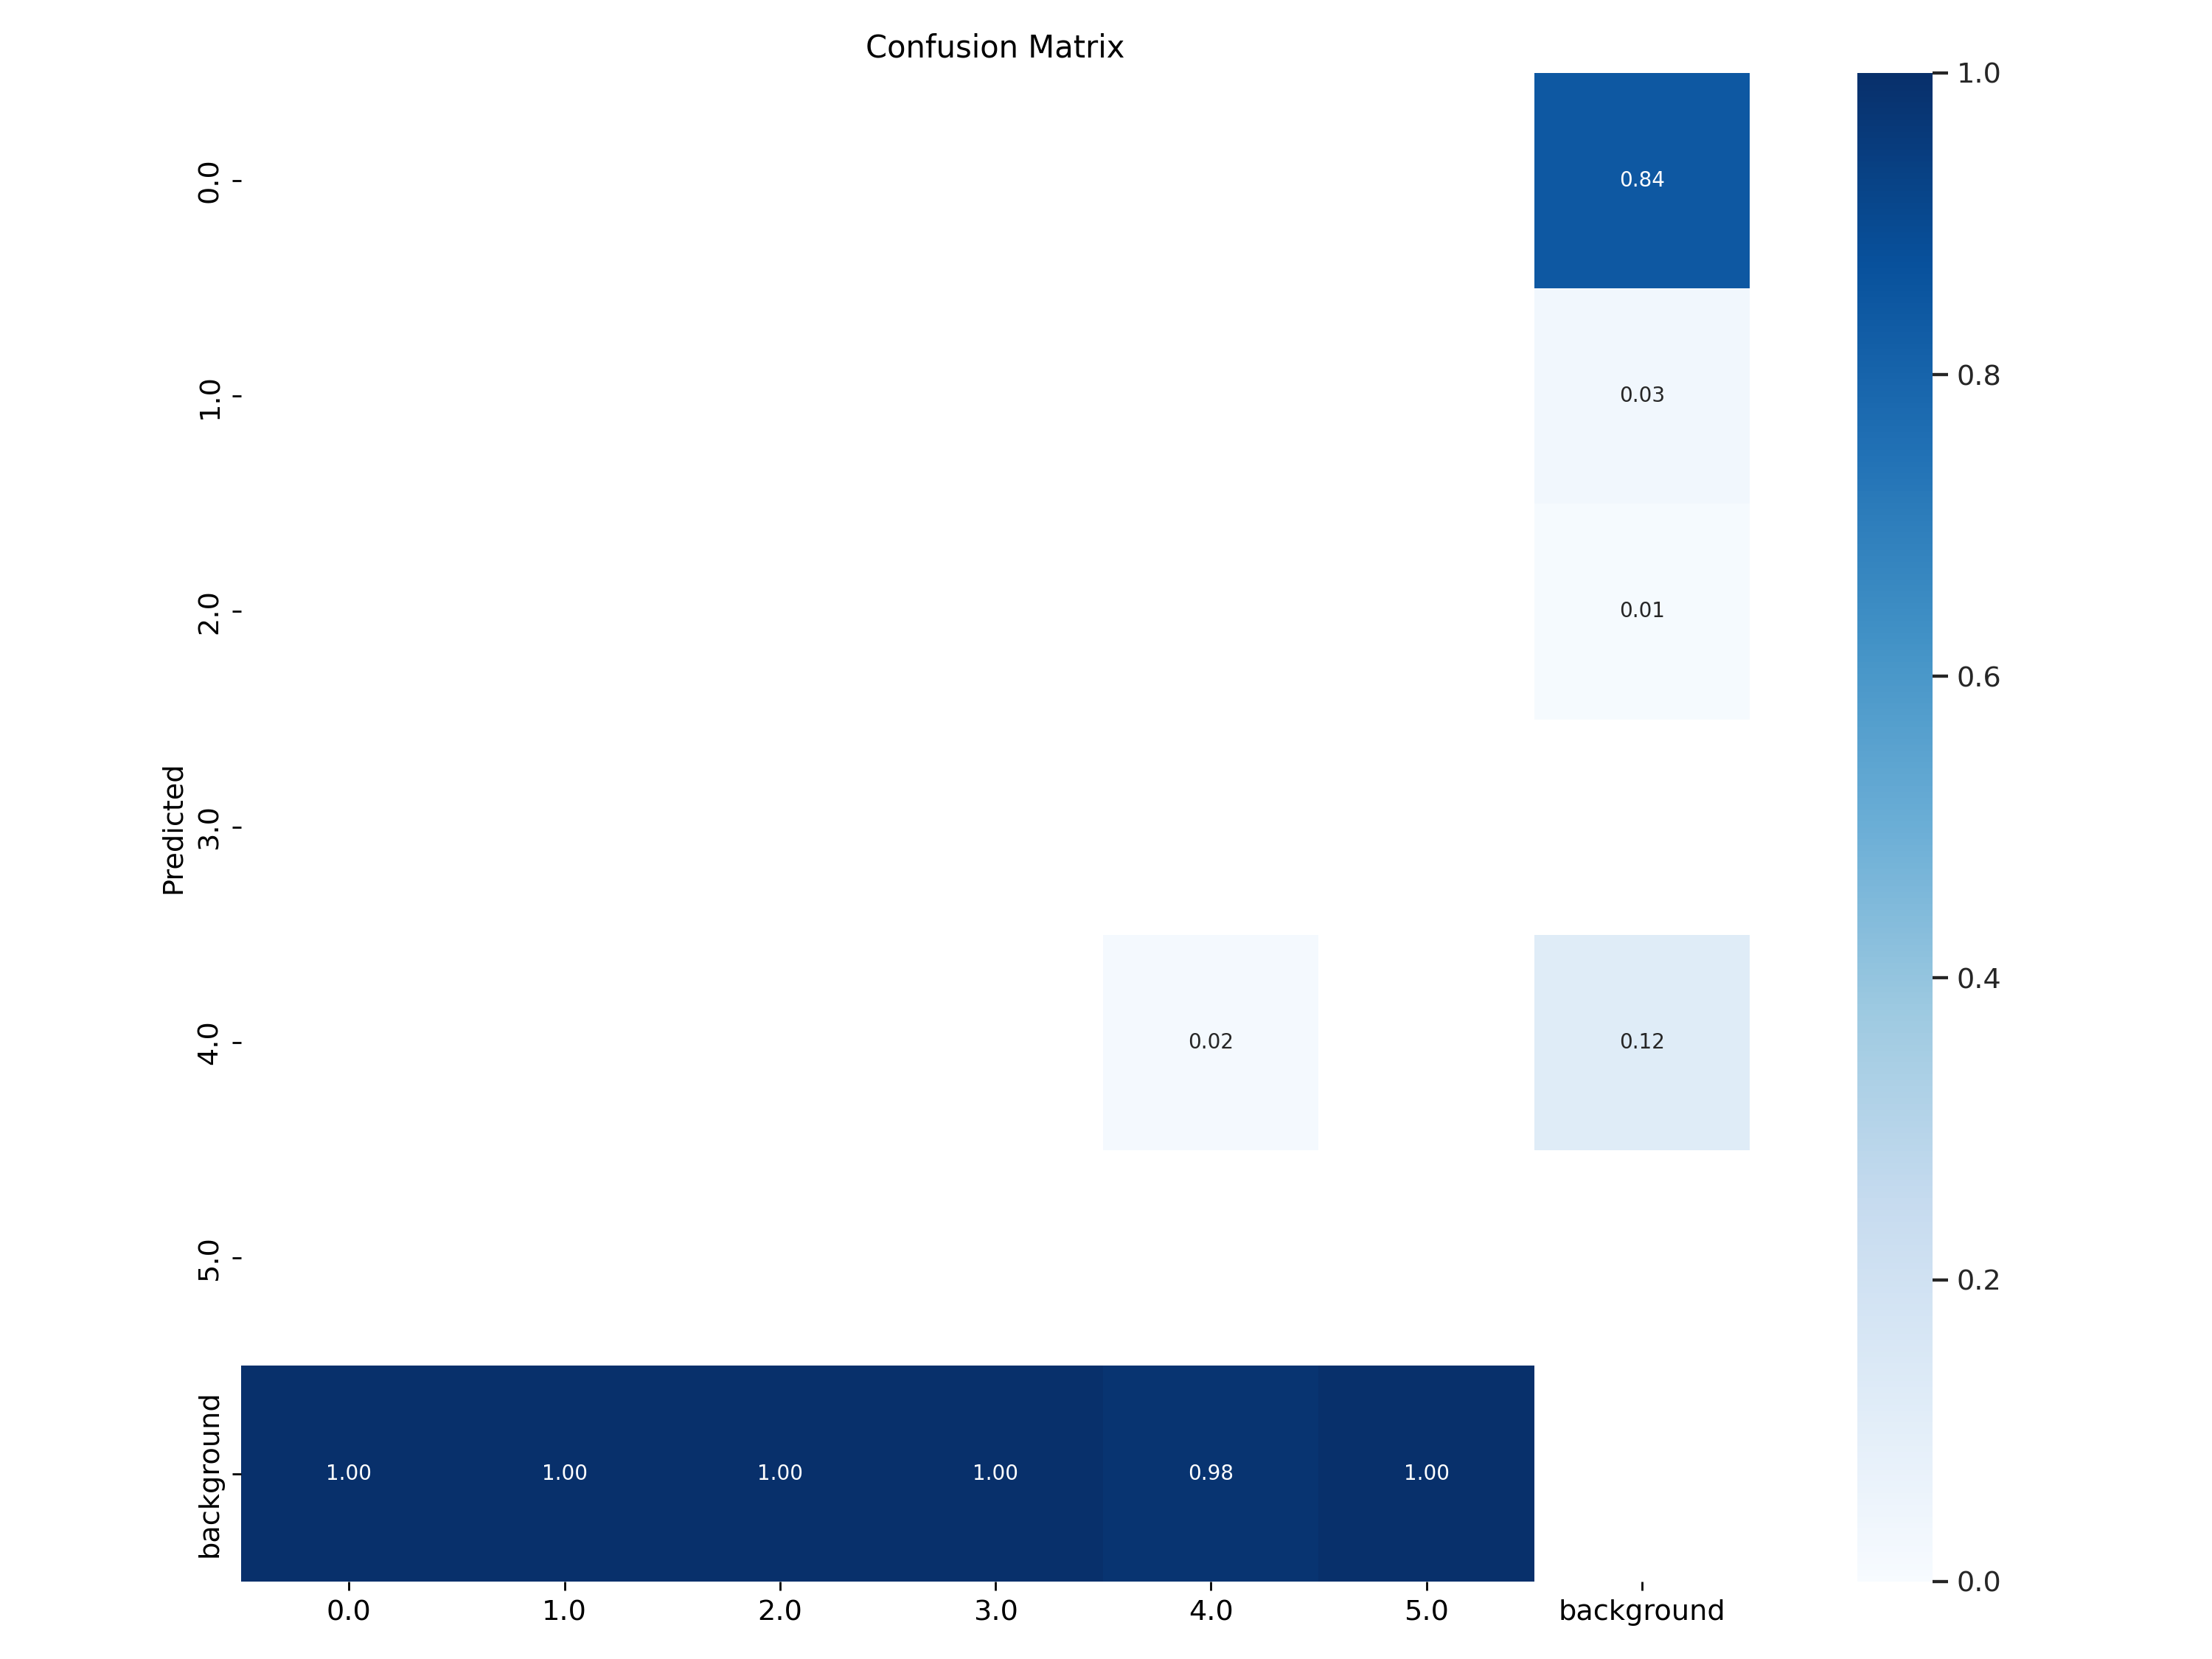

In [33]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/yolov9-c10/confusion_matrix.png", width=1000)

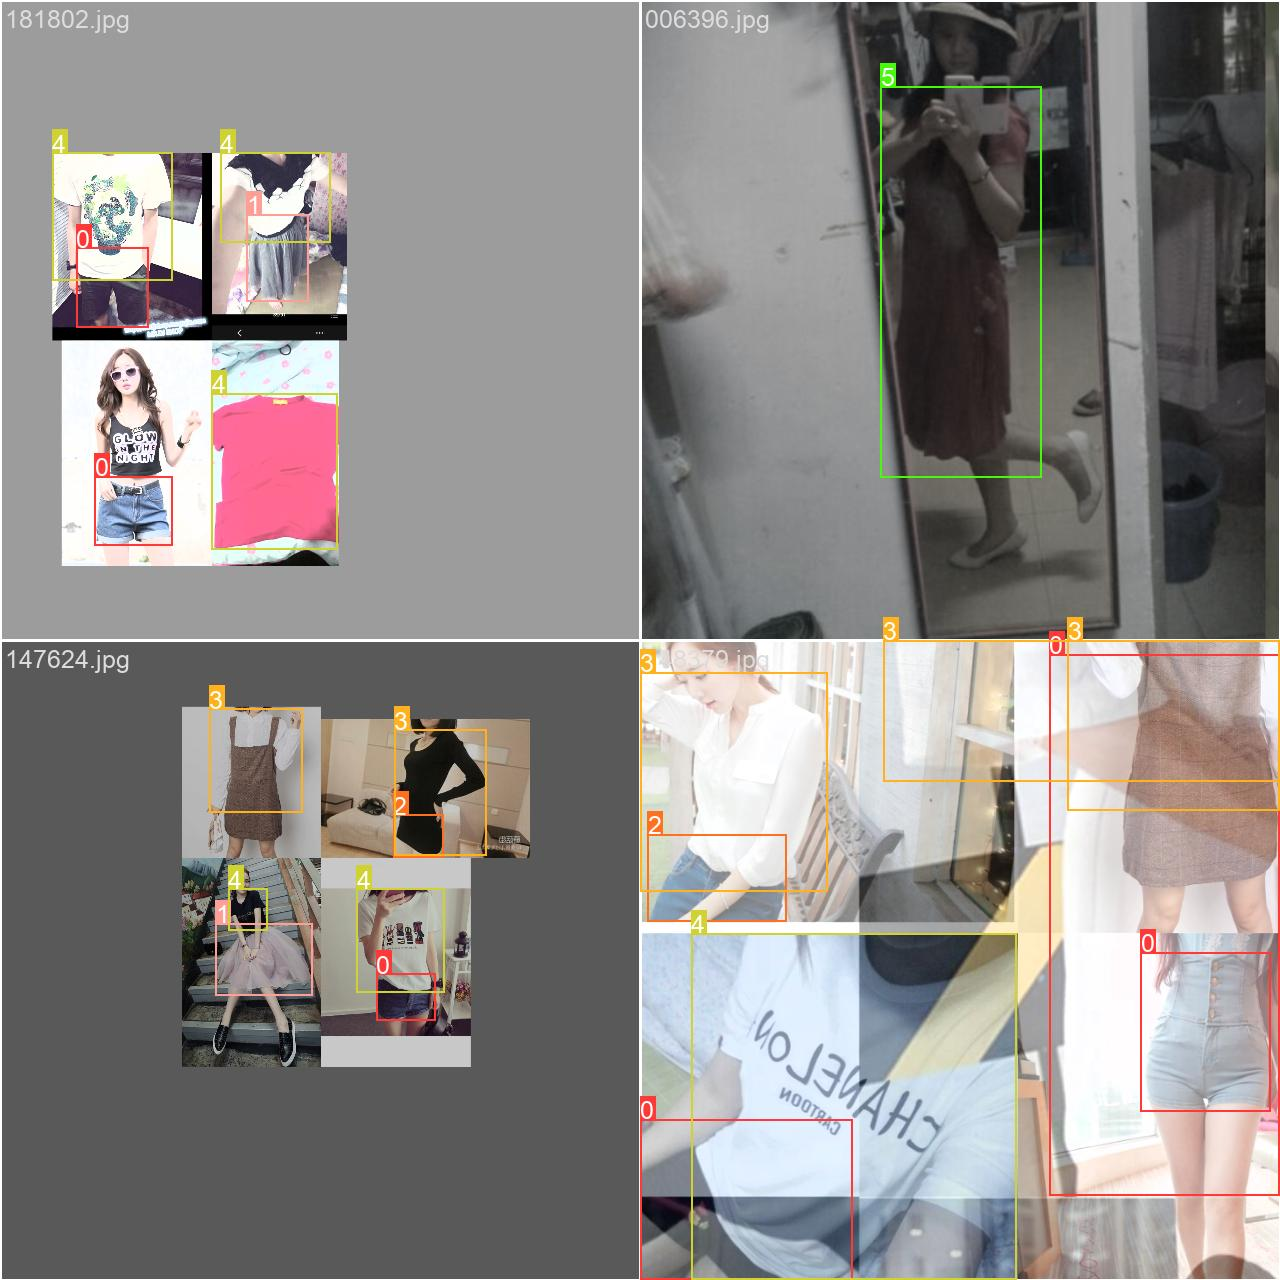

In [38]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/yolov9-c10/train_batch2.jpg", width=1000)

In [47]:
!python yolov9/val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data data.yaml \
--weights yolov9/runs/train/yolov9-c10/weights/best.pt

val: data=data.yaml, weights=['yolov9/runs/train/yolov9-c10/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov9/runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.12.3 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)

Fusing layers... 
yolov9-c summary: 724 layers, 50970180 parameters, 0 gradients, 237.7 GFLOPs
val: Scanning /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_
                 Class     Images  Instances          P          R      mAP50   
                   all        115        185    0.00266     0.0233     0.0069    0.00293
                   0.0        115         24    0.00347     0.0833    0.00271   0.000723
                   1.0        115         25     0.0081       0.04    0.00429

In [50]:
!python yolov9/detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights yolov9/runs/train/yolov9-c10/weights/best.pt \
--source yolo_data/test/images

detect: weights=['yolov9/runs/train/yolov9-c10/weights/best.pt'], source=yolo_data/test/images, data=yolov9/data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov9/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.12.3 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7940MiB)

Fusing layers... 
yolov9-c summary: 724 layers, 50970180 parameters, 0 gradients, 237.7 GFLOPs
image 1/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/001549.jpg: 1280x864 (no detections), 153.6ms
image 2/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/004062.jpg: 1280x960 (no detections), 141.6ms
image 3/62 /hom

image 54/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/171071.jpg: 1280x832 3 0.0s, 135.6ms
image 55/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/171676.jpg: 864x1280 (no detections), 86.2ms
image 56/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/175233.jpg: 1280x992 (no detections), 145.4ms
image 57/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/180434.jpg: 1120x1280 (no detections), 157.0ms
image 58/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/180936.jpg: 1280x960 (no detections), 97.6ms
image 59/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/181588.jpg: 1280x864 (no detections), 87.6ms
image 60/62 /home/akshay/Desktop/InternInterview/Matrice.ai/deep_fashion/yolo_data/test/images/187190.jpg: 864x1280 (no detections), 88.1ms
image 61/62 /home/akshay/

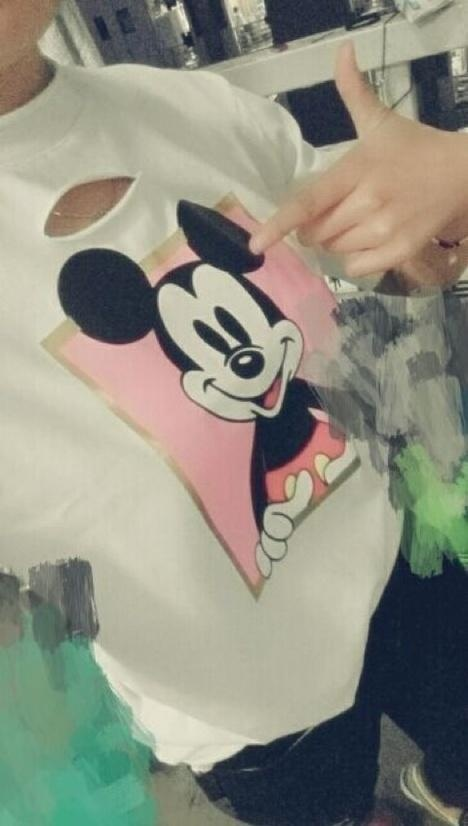

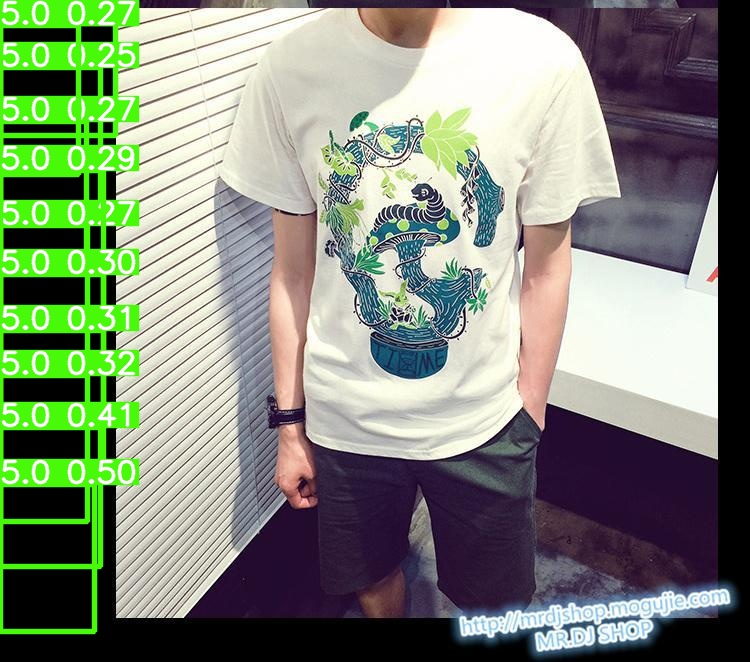

In [51]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp8/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))